### Extract product types and created content-based subcategories for music, cinema, and games with LDA
This script explored the category names and item names. With the help of Google translation, I extracted the major product tpyes from the category name, including games, cinema, music, books, etc. 

I found that games, cinema, and music are associated with most items and sales. What's more, unlike books whose category is already by genres, the category of cinema, music, and games are media-based (i.e. dvd or blu-ray?), not content-based. 

This motivated me to use LDA to extract latent topics based on genra names and created finer sub-categories for music, cinema, and games. The finer sub-categories (item_category_id2) can be used directly in place of item_category_id.

In [1]:
import os
import re
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation  # for LSA
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tqdm import tqdm_notebook

In [3]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### Understand the categories

In [5]:
cat0 = pd.read_csv(r'../data/item_categories.csv')
print(cat0.shape)
cat0[:3]

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [6]:
# def get_fst(x):
    
#     x = re.split("-",x)[0].strip()
    
#     return(x)

# def get_snd(x):
    
#     x = re.split("-",x)[1].strip() if len(re.split("-",x))>1 else ''
    
#     return(x)

In [7]:
def normalize_cat_name(x):
    
    x = x.lower()    
    x = re.sub('xbox 360','xbox_360',x)
    x = re.sub('xbox one','xbox_one',x)
    x = re.sub('книги','book',x)
    x = re.sub('настольные игры','board_games',x)
    x = re.sub('игры','games',x)
    x = re.sub('музыка','music',x)
    x = re.sub('кино','cinema',x)
    x = re.sub('карты оплаты','pmt_card',x)
    x = re.sub('подарки','presents',x)
    x = re.sub('программы','programs',x)
    x = re.sub('служебные','service',x)
    x = re.sub('аксессуары','accessory',x)
    x = re.sub('игровые консоли','game_console',x)
    
    return x

In [8]:
def get_sys(x):
    
    x = x.lower()
    pattern = 'pc|windows|mac|android|ps2|ps3|ps4|psp|psvita|xbox_one|xbox_360|psn|mp3|dvd|blu-ray|cd'
    
    sys = re.findall(pattern,x)[0] if len(re.findall(pattern,x))>0 else 'other'
    
    return sys
   
def get_product(x):
    
    pattern = 'book|games|game_console|board_games|pmt_card|cinema|music|programs|presents|service|accessory'
    
    prod = re.findall(pattern,x)[0] if len(re.findall(pattern,x))>0 else 'other'
    
    return prod

In [9]:
cat0['item_category_name2'] = cat0['item_category_name'].map(normalize_cat_name)
# cat0['fst'] = cat0.item_category_name2.map(get_fst)
# cat0['snd'] = cat0.item_category_name2.map(get_snd)
cat0['sys'] = cat0['item_category_name2'].map(get_sys)
cat0['product'] = cat0['item_category_name2'].map(get_product)

In [10]:
cat0['product'].value_counts()

games           14
book            13
presents        12
game_console     8
accessory        7
programs         6
other            6
music            6
pmt_card         5
cinema           5
service          2
Name: product, dtype: int64

In [11]:
cat0[cat0['product']=='other']

,item_category_name,item_category_id,item_category_name2,sys,product
0,PC - Гарнитуры/Наушники,0,pc - гарнитуры/наушники,pc,other
8,Билеты (Цифра),8,билеты (цифра),other,other
9,Доставка товара,9,доставка товара,other,other
81,Чистые носители (шпиль),81,чистые носители (шпиль),other,other
82,Чистые носители (штучные),82,чистые носители (штучные),other,other
83,Элементы питания,83,элементы питания,other,other


#### Read in items

In [12]:
items0 = pd.read_csv(r'../data/items.csv')

In [13]:
print(items0.item_category_id.nunique(), items0.item_id.nunique())

84 22170


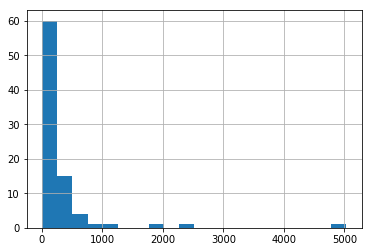

In [15]:
items0.groupby('item_category_id')['item_id'].count().sort_values(ascending=False).hist(bins=20) # some super big classes exist

In [16]:
items1 = pd.merge(items0,cat0[['item_category_id', 'sys','product','item_category_name2']],on=['item_category_id'],how='left')
items1['product'].value_counts()

cinema          7464
music           4325
games           3955
presents        3528
book            1273
programs        1152
accessory        219
game_console     150
other             55
pmt_card          42
service            7
Name: product, dtype: int64

In [17]:
items1['product'].value_counts()/cat0['product'].value_counts()   # Averge Items per sub category

accessory         31.285714
book              97.923077
cinema          1492.800000
game_console      18.750000
games            282.500000
music            720.833333
other              9.166667
pmt_card           8.400000
presents         294.000000
programs         192.000000
service            3.500000
Name: product, dtype: float64

#### Unlike book and presents that is already categorized by genra, cinema, music, and games are categorized by media (cd/dvd/blu-ray, etc.) or system (pc, ps4, etc.), which could use some content-based categorization

In [18]:
sales = pd.read_csv(r'../data/sales_train.csv.gz')
sales.shape

(2935849, 6)

In [19]:
sales1 = pd.merge(sales, items1,on=['item_id'],how='left')

In [20]:
sales1.groupby('product')['item_cnt_day'].sum()#.plot()

product
accessory         85056.0
book              76341.0
cinema           916943.0
game_console      32155.0
games           1335994.0
music            411294.0
other             55254.0
pmt_card          53883.0
presents         584366.0
programs          74954.0
service           21966.0
Name: item_cnt_day, dtype: float64

In [21]:
sales1['month'] = (np.mod(sales1.date_block_num,12)+1).astype(np.int8)
sales1[sales1['month']==1].groupby('product')['item_cnt_day'].sum()#.plot()

# check November (clearly nobody read books lol)

product
accessory        10770.0
book              6167.0
cinema           98632.0
game_console      3291.0
games           127804.0
music            38234.0
other             4030.0
pmt_card          5667.0
presents         54005.0
programs          9089.0
service           1660.0
Name: item_cnt_day, dtype: float64

#### Further confirmed in sales that games, cinema, and music (and presents) are the big category and worth content-based feature extraction.

Wikipedia gives 8 genres for games, 24 for movies, 16 for music;

So I'll just use LSA to categorize movie, music, and games each into 50 sub-category by contents

In [22]:
items1['item_name2'] = items1.item_name.map(lambda x: re.sub('[0-9]+','_num_',x))
items1[:3]

,item_name,item_id,item_category_id,sys,product,item_category_name2,item_name2
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,dvd,cinema,cinema - dvd,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,other,programs,programs - для дома и офиса (цифра),!ABBYY FineReader _num_ Professional Edition F...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,dvd,cinema,cinema - dvd,***В ЛУЧАХ СЛАВЫ (UNV) D


In [23]:
arr = np.array([1, 3, 2, 4, 5])
top3=arr.argsort()[-3:][::-1]

In [24]:
arr[top3]

array([5, 4, 3])

Grid search doesn't help much in choosing the best number of topics based on what I read... I tried a range of topics, and it always seems the fewer topics the better. Need to read more about this.

In [ ]:
# test = items1.loc[items1['product']=='cinema','item_name2']
# params = {'n_components':list(range(8,26,4))}
# lda = LatentDirichletAllocation(random_state=23141)
# model = GridSearchCV(lda,params,cv=3)

# tf = TfidfVectorizer(max_df=0.7,min_df=5,stop_words='english')
# tfidf_mat = tf.fit_transform(test)

# model.fit(tfidf_mat)

# model.best_params_

In [26]:
models = {}

for prod,n_genres in tqdm_notebook([('games',8),('cinema',24),('music',16)]):
    
    data = items1.loc[items1['product']==prod,'item_name2']
    ind = data.index
    
    tf = TfidfVectorizer(max_df=0.7,min_df=5,stop_words='english')
    tfidf_mat = tf.fit_transform(data)
    
    lda = LatentDirichletAllocation(n_components=n_genres,random_state=23141)
    lda_res = lda.fit_transform(tfidf_mat) 
    
    models[prod]={'lda':lda, 'tfidf_mat':tfidf_mat, 'tf':tf, 'result':lda_res, 'ind':ind}

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

In [27]:
## Inspect the LDA result
prod = 'games'
pyLDAvis.sklearn.prepare(models[prod]['lda'],models[prod]['tfidf_mat'],models[prod]['tf'])

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      14.765269        1       1 -0.025587  0.040346
0      13.506084        1       2  0.143422  0.089999
6      13.449280        1       3  0.159360 -0.013595
1      13.283750        1       4  0.089078 -0.279558
3      12.688647        1       5 -0.139832 -0.003293
4      11.469303        1       6  0.035550  0.174090
7      11.119066        1       7 -0.256841 -0.033783
2       9.718603        1       8 -0.005150  0.025794, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
670   Default  107.000000       субтитры  107.000000  30.0000  30.0000
646   Default  106.000000        русские  106.000000  29.0000  29.0000
144   Default   59.000000     essentials   59.000000  28.0000  28.0000
301   Default   61.000000             ps   61.000000  27.0000  27.0000
705   Default  266.000000       цифровая  266.000000  26.0000  26.0000
303   Default   53.000000            psp   53.000000  25.0000  25.0000
538   Default   75.000000        издание   75.000000  24.0000  24.0000
590   Default   46.000000          набор   46.000000  23.0000  23.0000
130   Default   55.000000            dvd   55.000000  22.0000  22.0000
462   Default  106.000000     английская  106.000000  21.0000  21.0000
450   Default  149.000000           xbox  149.000000  20.0000  20.0000
425   Default   39.000000           vita   39.000000  19.0000  19.0000
356   Default   40.000000     skylanders   40.000000  18.0000  18.0000
302   Default  194.000000        ps_num_  194.000000  17.0000  17.0000
88    Default   42.000000          creed   42.000000  16.0000  16.0000
26    Default   41.000000       assassin   41.000000  15.0000  15.0000
283   Default  348.000000             pc  348.000000  14.0000  14.0000
210   Default  188.000000          jewel  188.000000  13.0000  13.0000
431   Default   41.000000            war   41.000000  12.0000  12.0000
543   Default   32.000000  интерактивная   32.000000  11.0000  11.0000
695   Default   32.000000        фигурка   32.000000  10.0000  10.0000
663   Default   29.000000       софтклаб   29.000000   9.0000   9.0000
508   Default   45.000000            для   45.000000   8.0000   8.0000
118   Default   42.000000         disney   42.000000   7.0000   7.0000
134   Default  101.000000        edition  101.000000   6.0000   6.0000
682   Default   32.000000         только   32.000000   5.0000   5.0000
48    Default   28.000000    borderlands   28.000000   4.0000   4.0000
560   Default   28.000000  коллекционное   28.000000   3.0000   3.0000
157   Default   39.000000           fifa   39.000000   2.0000   2.0000
510   Default   94.000000   документация   94.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
384    Topic8   10.687829          super   11.493968   2.2584  -4.3868
661    Topic8    9.709185        снайпер   10.516842   2.2512  -4.4828
261    Topic8    9.335643            new   10.141537   2.2483  -4.5221
233    Topic8    8.779138            mac    9.585194   2.2433  -4.5835
225    Topic8    8.653728          light    9.459503   2.2421  -4.5979
135    Topic8    8.620593         effect    9.426283   2.2418  -4.6018
243    Topic8    8.620580           mass    9.426282   2.2418  -4.6018
160    Topic8    7.783514       football    8.589149   2.2326  -4.7039
316    Topic8    7.387903          recon    8.196459   2.2273  -4.7561
188    Topic8    7.245140           hell    8.050935   2.2257  -4.7756
73     Topic8    6.449392        classic    7.255293   2.2134  -4.8919
301    Topic8   54.932024             ps   61.950753   2.2109  -2.7498
182    Topic8    6.036315           grid    6.842845   2.2057  -4.9581
383    Topic8    6.017398     stronghold    6.825204   2.2052  -4.9613
509    Topic8    5.963280           дней    6.768959   2.2044  -4.9703
421    To

In [28]:
TOP_N = 3
top_n_res_list = []

for prod in models.keys():
    cats = np.zeros((models[prod]['result'].shape[0],TOP_N),dtype=np.int16)
    probs = np.zeros((models[prod]['result'].shape[0],TOP_N))

    for i,row in enumerate(models[prod]['result']):
        cats[i,:] = np.argsort(row)[-TOP_N:][::-1]
        probs[i,:] = row[cats[i,:]]

    top_cat_prob = pd.DataFrame(np.hstack((cats,probs)),index=models[prod]['ind'])
    
    top_n_res_list.append(top_cat_prob)

In [29]:
top_n_res_df = pd.concat(top_n_res_list)
top_n_res_df.columns = ['cat1','cat2','cat3','cat1_prob','cat2_prob','cat3_prob']
print(top_n_res_df.shape)
top_n_res_df[:30]

(15744, 6)


,cat1,cat2,cat3,cat1_prob,cat2_prob,cat3_prob
27,0.0,6.0,3.0,0.698312,0.043131,0.043104
28,5.0,0.0,6.0,0.410990,0.350344,0.039785
29,0.0,6.0,3.0,0.706690,0.041977,0.041897
68,7.0,5.0,1.0,0.704615,0.042266,0.042210
105,4.0,1.0,3.0,0.414043,0.192125,0.184500
106,6.0,1.0,5.0,0.356675,0.308397,0.140081
499,1.0,5.0,2.0,0.679642,0.045779,0.045763
500,1.0,4.0,5.0,0.659108,0.129806,0.035202
501,1.0,3.0,5.0,0.723540,0.039584,0.039502
502,1.0,5.0,3.0,0.566883,0.225739,0.034611


In [30]:
items2 = pd.merge(items1,top_n_res_df,left_index=True, right_index=True, how='left')

# Fill NAs with 0 for other products other than cinema, music, and games;
# This would assign a default 'dominant' category for all other products;
items2.fillna(0,inplace=True)
items2.loc[items2.cat1_prob==0,'cat1_prob']=1
items2[:3]

,item_name,item_id,item_category_id,sys,product,item_category_name2,item_name2,cat1,cat2,cat3,cat1_prob,cat2_prob,cat3_prob
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,dvd,cinema,cinema - dvd,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,16.0,23.0,10.0,0.520833,0.020833,0.020833
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,other,programs,programs - для дома и офиса (цифра),!ABBYY FineReader _num_ Professional Edition F...,0.0,0.0,0.0,1.000000,0.000000,0.000000
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,dvd,cinema,cinema - dvd,***В ЛУЧАХ СЛАВЫ (UNV) D,23.0,22.0,1.0,0.041667,0.041667,0.041667


### Noticed that item_name also indicate whether dvd/cd/blu-ray, etc.; get those

In [37]:
items2['sys'].value_counts()

other       7650
dvd         5035
cd          2762
pc          2171
blu-ray     2097
ps3          744
xbox_360     578
mp3          427
ps4          229
xbox_one     167
psp          146
psvita       126
mac           16
ps2            9
windows        6
psn            4
android        3
Name: sys, dtype: int64

In [32]:
def get_sys2(x):
    
    x = x.lower()
    x = re.sub('xbox 360','xbox_360',x)
    x = re.sub('xbox one','xbox_one',x)
    
#     pattern = 'pc|windows|mac|android|ps2|ps3|ps4|psp|psvita|xbox_one|xbox_360|psn|mp3|dvd|blu-ray|cd'
    pattern = 'pc|windows|mac|ps2|ps3|ps4|psp|psvita|xbox_one|xbox_360|psn|mp3|dvd|blu-ray|cd'  # removed android, which could be game
    
    sys = re.findall(pattern,x)[0] if len(re.findall(pattern,x))>0 else 'other'
    
    return sys

In [38]:
items2.loc[items2.sys=='other','sys'] = items2.loc[items2.sys=='other','item_name'].map(get_sys2)

In [39]:
items2['sys'].value_counts()

other       5878
dvd         5489
cd          2979
pc          2820
blu-ray     2141
mp3          788
ps3          744
xbox_360     581
ps4          229
xbox_one     167
psp          146
psvita       126
mac           42
windows       24
ps2            9
psn            4
android        3
Name: sys, dtype: int64

763


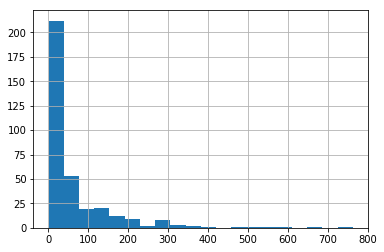

In [44]:
items2['item_category_id2'] = items2.item_category_id.astype(str) + '-'+items2.cat1.astype(int).astype(str)
print(items2['item_category_id2'].value_counts().max())
items2['item_category_id2'].value_counts().hist(bins=20)

In [46]:
(items2['item_category_id2'].value_counts()<5).sum()

62

In [47]:
(items2['item_category_id'].value_counts()<5).sum()

10

In [53]:
items2[['item_id', 'item_category_id', 'sys', 'product',
        'cat1', 'cat2', 'cat3','cat1_prob', 'cat2_prob', 'cat3_prob',
        'item_category_id2']].to_csv(r'../data2/item_category2.csv',index=False)